In [ ]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.applications.vgg19 import preprocess_input,VGG19                             #Importing Libraries needed
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')                                                                 #Drive Mounting

Mounted at /gdrive/


In [ ]:
data_dir= '/gdrive/MyDrive/AdvancedSignalProcessing/ED6001_data/Training'             #Give training dataset path here
print(data_dir)

/gdrive/MyDrive/AdvancedSignalProcessing/ED6001_data/Training


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io

In [ ]:
#Data Preparation

In [ ]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_X = []
train_Y  = []
test_X = []
test_Y = []
image_size=150
for label in labels:
    train_path = os.path.join(data_dir,label)
    for file in tqdm(os.listdir(train_path)):
        image = cv2.imread(os.path.join(train_path, file))
        image = cv2.resize(image, (image_size, image_size))
        train_X.append(image)
        train_Y.append(label)
    
train_X = np.array(train_X)

100%|██████████| 827/827 [02:33<00:00,  5.38it/s]


In [ ]:
for label in labels:
  
    test_path = os.path.join('/gdrive/MyDrive/AdvancedSignalProcessing/ED6001_data/Testing',label)
    for file in tqdm(os.listdir(test_path)):
        image = cv2.imread(os.path.join(test_path, file))                                 #give Test data path here
        image = cv2.resize(image, (image_size, image_size))
        test_X.append(image)
        test_Y.append(label)
    
test_X = np.array(test_X)

100%|██████████| 74/74 [00:13<00:00,  5.38it/s]


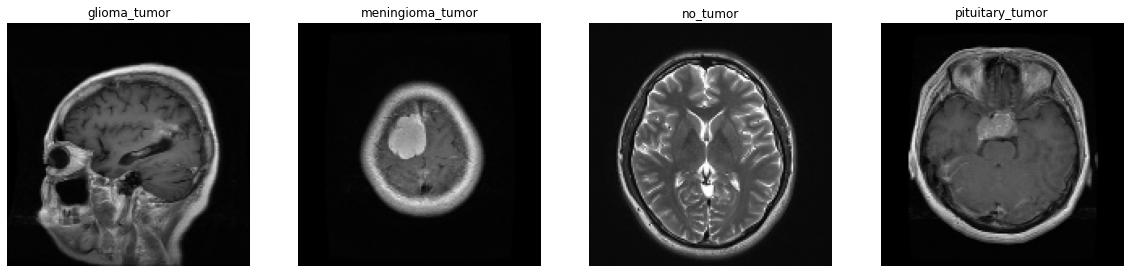

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
k = 0
for i in range(0,4):
    if i==0: idx=0
    elif i==1: idx=827
    elif i==2: idx=1649
    else: idx=2045
    ax[k].imshow(train_X[idx])
    ax[k].set_title(train_Y[idx])
    ax[k].axis('off')
    k+=1

In [ ]:
train_X, train_Y = shuffle(train_X, train_Y, random_state=28)
print(train_X.shape)                                                              #Shuffling dataset

(2870, 150, 150, 3)


In [ ]:
#One hot encoding

In [ ]:
train_Y_ = []
for i in train_Y:
    train_Y_.append(labels.index(i))
train_Y = train_Y_

train_Y = tf.keras.utils.to_categorical(train_Y)

test_Y_ = []
for i in test_Y:
    test_Y_.append(labels.index(i))
test_Y = test_Y_

test_Y = tf.keras.utils.to_categorical(test_Y)

In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=28) #splitting dataset into training and validation

In [ ]:
#Transfer Learning
#VGG16 is taken as base model and new layers are added to it for classification.

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [ ]:
#ImageDataGenerator is used for data augmentation pupose.
#Image augmentation is a technique of applying different transformations to original images which results in multiple transformed copies of the same image.
#like rotated,flipped etc. 

In [ ]:
data_generation = ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
featurewise_std_normalization=False,
samplewise_std_normalization=False,
zca_whitening=False,
rotation_range=10,
zoom_range=0.1,
width_shift_range=0.1,
horizontal_flip=False,
vertical_flip=False)

data_generation.fit(train_X)

In [ ]:
history = model.fit_generator(data_generation.flow(train_X, train_Y, batch_size=32),
                              validation_data=(val_X, val_Y), 
                              epochs=20, 
                              verbose=1,
                            callbacks=[tensorboard, checkpoint, reduce_lr])

Epoch 1/20
72/72 [==============================] - ETA: 0s - loss: 0.5663 - accuracy: 0.7679
Epoch 00001: val_accuracy did not improve from 0.75087
72/72 [==============================] - 33s 463ms/step - loss: 0.5663 - accuracy: 0.7679 - val_loss: 0.6993 - val_accuracy: 0.6899 - lr: 9.0000e-05
Epoch 2/20
72/72 [==============================] - ETA: 0s - loss: 0.5291 - accuracy: 0.7822
Epoch 00002: val_accuracy improved from 0.75087 to 0.80139, saving model to brain_tumor_classification.h5
72/72 [==============================] - 34s 467ms/step - loss: 0.5291 - accuracy: 0.7822 - val_loss: 0.5101 - val_accuracy: 0.8014 - lr: 9.0000e-05
Epoch 3/20
72/72 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.7936
Epoch 00003: val_accuracy did not improve from 0.80139
72/72 [==============================] - 33s 459ms/step - loss: 0.5136 - accuracy: 0.7936 - val_loss: 0.5954 - val_accuracy: 0.7875 - lr: 9.0000e-05
Epoch 4/20
72/72 [==============================] - ETA

In [ ]:
final_model = tf.keras.models.load_model('./classification.h5')

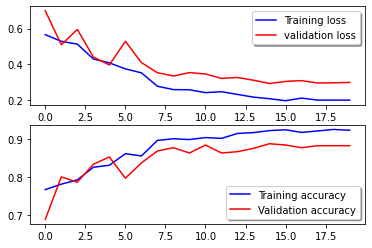

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
#Predictions on Test Datasets using VGG16 model

prediction=np.argmax(model.predict(test_X),axis=1)
y= np.argmax(test_Y,axis=1)
print(classification_report(y,prediction))

              precision    recall  f1-score   support

           0       0.94      0.17      0.29       100
           1       0.69      0.71      0.70       115
           2       0.45      0.90      0.60       105
           3       0.76      0.46      0.57        74

    accuracy                           0.58       394
   macro avg       0.71      0.56      0.54       394
weighted avg       0.70      0.58      0.54       394



In [ ]:
#Defining function for confusion matrix plot
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')



    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


    #Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization
AxesSubplot(0.2563,0.147513;0.577817x0.831059)


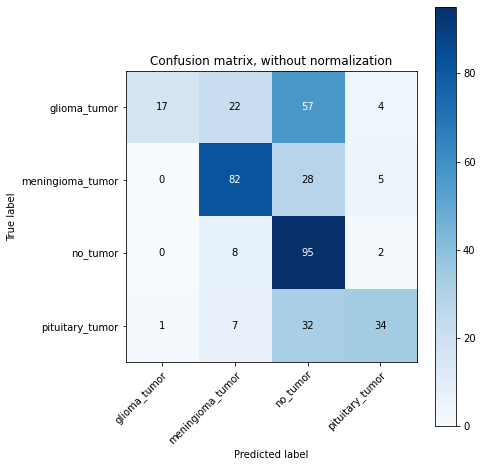

In [ ]:
from sklearn.metrics import confusion_matrix
print(plot_confusion_matrix(y,prediction,classes = labels))